In [2]:
import pandas as pd 
import requests
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer,QuantileTransformer,StandardScaler,MinMaxScaler
from neuralprophet import NeuralProphet, set_log_level
# Disable logging messages unless there is an error
set_log_level("ERROR")

import warnings
warnings.filterwarnings('ignore')

url = 'https://dashboard-api.tgju.org/v1/tv/history?symbol=PRICE_DOLLAR_RL&resolution=1D&from=1681492565&to=1712678305'
try:
    res = requests.get(url=url)
    res_j = res.json()
except requests.exceptions.RequestException as e:
    print(f"Error occurred during request: {e}")

# Get the column names from the dictionary
column_names = list(res_j.keys())

res_j.pop('s')
res_j.pop('v')

# Create the DataFrame
try:
  df = pd.DataFrame.from_dict(res_j)
except pd.errors.ParserError as e:
  print(f"Error occurred while parsing the data: {e}")

# Convert the unix timestamp column to datetime
try:
  df['t'] = pd.to_datetime(df['t'],unit='s')
except pd.errors.OutOfBoundsDatetime as e:
  print(f"Error occurred while converting the timestamp: {e}")

df.to_csv('df.csv', index=False)
# Select the relevant columns
dfs = df[['t','c']].copy()
# Rename the columns
dfs.rename(columns={'t':'ds','c':'y'}, inplace= True)
# Filter the data to start from 2017-01-01
dfs = dfs[dfs['ds'] >= '2017-01-01'].reset_index().drop(columns='index')
# Drop duplicates
dfs = dfs.drop_duplicates(subset=['ds'])

scaler = MinMaxScaler()
dfs["y"] = scaler.fit_transform(dfs["y"].values.reshape(-1, 1))

# Save the DataFrame to a CSV file
dfs.to_csv('df.csv', index=False)
dfs

,ds,y
0,2017-01-01,0.002542
1,2017-01-02,0.003116
2,2017-01-03,0.002886
3,2017-01-04,0.002936
4,2017-01-06,0.002952
...,...,...
2396,2024-03-28,0.950112
2397,2024-04-02,0.976876
2398,2024-04-03,0.979894
2399,2024-04-04,0.990160


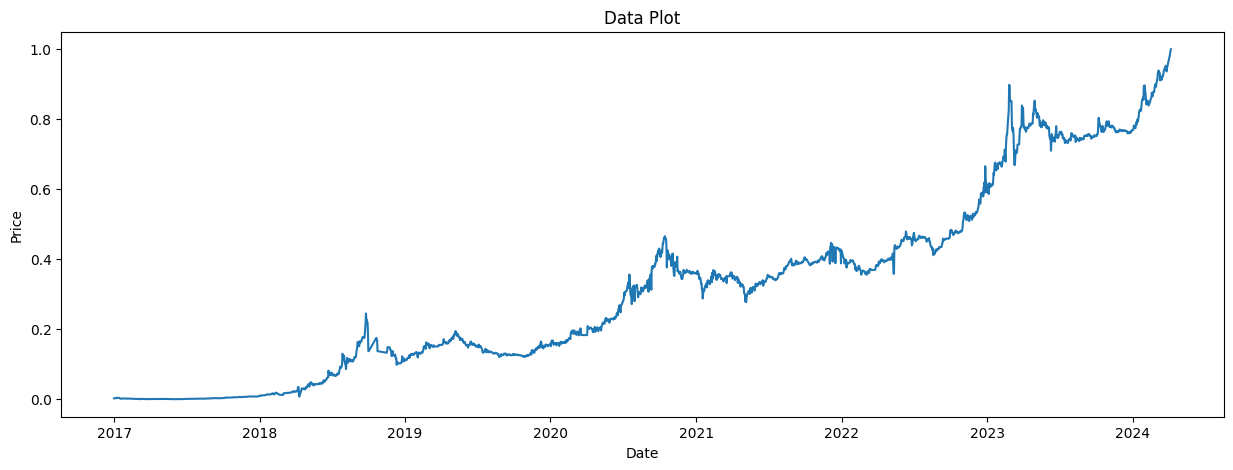

In [3]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Check if the DataFrame 'dfs' is empty
if dfs.empty:
    print("Error: DataFrame is empty.")
    # Handle the error as desired, e.g., raise an exception or return an error message

# # Normalise the 'y' column
# dfs["y2"] = (dfs["y"] - dfs["y"].min()) / (dfs["y"].max() - dfs["y"].min())

# scaler = MinMaxScaler()
# dfs["y3"] = scaler.fit_transform(dfs["y"].values.reshape(-1, 1))

# scaler = StandardScaler()
# dfs["y4"] = scaler.fit_transform(dfs["y"].values.reshape(-1, 1))

# transformer = QuantileTransformer(n_quantiles=10)
# dfs["y5"] = transformer.fit_transform(dfs["y"].values.reshape(-1, 1))

# normalizer = Normalizer(norm="l2")
# dfs["y6"] = normalizer.fit_transform(dfs["y"].values.reshape(-1, 1))
# Plot the data
ax.plot(dfs["ds"], dfs["y"])

# Add labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Data Plot")

# Display the plot
plt.show()

In [4]:
# Create a NeuralProphet model
m = NeuralProphet(
)
m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
m = m.add_country_holidays("IR")


# Split the data into training and testing sets
df_train, df_test = m.split_df(dfs, freq="D", valid_p=1.0 / 12)

# Fit the model to the training data
metrics = m.fit(df_train, freq="D", validation_df=df_test, progress="plot")


# Print the model metrics
print(metrics)

: 

In [ ]:
# Create a forecast object using the model
forecast = m.predict(df_train)

# Set the plotting backend to "plotly-static"
m.set_plotting_backend("plotly-static")

# Plot the forecast using the set plotting backend
m.plot(forecast)

In [ ]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast[-7 * 24 :])

In [ ]:
m.plot_parameters()


In [ ]:
# Python function to test
